In [1]:
from load_modules import *
import copy


In [2]:
plt.rcParams['figure.figsize'] = (14.0, 3.0)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 1

def create_exp(x):
    return np.random.uniform(80,100)*np.exp(np.linspace(1,np.random.uniform(-1,-50),len(x))) 

def create_poly(x):
    max_power = np.random.randint(3,7)
    y = np.ones(x.shape) * np.random.uniform(20,40) + (max_power-1) * 30
    for power in range(1, max_power):
        y -= np.linspace(-1,1,len(x))**power * np.random.uniform(20,40)
    return y

def create_gaus(x):
    mu = np.random.uniform(600,800) * (end-start) / steps
    sigma = np.random.uniform(200,500)
    return np.exp(-0.5* ((x - mu)**2 / sigma**2)) * np.random.uniform(20,40)

def norm(e):
    return (e - np.min(e)) / (np.max(e) - np.min(e))

def create_dummy_spectra(n_spectra=100, expo=True, poly=True, gaus=True, raman=True):
    global raw_lst
    raw_lst = []
    for _ in range(n_spectra):
        photo  = np.zeros(x.shape)
        if expo:
            photo += create_exp(x)
        if poly:
            photo += create_poly(x)
        if gaus:
            photo += create_gaus(x)
        photo -= min(-5, np.min(photo))
        raw = copy.copy(photo)
                
        if raman:
            for _ in range(20):
                FWHM_spike = np.random.uniform(7,80)
                raman_mu = int(n*np.random.uniform(0.1,0.9))
                raw +=  np.random.uniform(5,10) * LSQ.gaussian(x, np.array([raman_mu]), np.array([FWHM_spike / (2 * np.sqrt(2 * np.log(2)))])).reshape(-1)
            for _ in range(10):
                FWHM_spike = np.random.uniform(7,40)
                raman_mu = int(n*np.random.uniform(0.1,0.9))
                raw +=  np.random.uniform(10,20) * LSQ.gaussian(x, np.array([raman_mu]), np.array([FWHM_spike / (2 * np.sqrt(2 * np.log(2)))])).reshape(-1)
            for _ in range(6):
                FWHM_spike = np.random.uniform(7,40)
                raman_mu = int(n*np.random.uniform(0.1,0.9))
                raw +=  np.random.uniform(20,80) * LSQ.gaussian(x, np.array([raman_mu]), np.array([FWHM_spike / (2 * np.sqrt(2 * np.log(2)))])).reshape(-1)
        
        raw += np.random.random(x.shape) * 5
        raw_lst.append((raw, photo))
    raw_lst = np.array(raw_lst)


In [3]:
# end = 2000
# start = 80
# steps = 1250
# n = end-start
# x = np.linspace(start, end, steps)

# raw_lst = []
# create_dummy_spectra(n_spectra=1000, expo=True, poly=True, gaus=True, raman=True)

# raw = np.array(raw_lst)[:,0].reshape(1,-1,100,len(x))
# photo = np.array(raw_lst)[:,1].reshape(1,-1,100,len(x))

# shapes = [raw[0].shape[:-1]]
# save_variables = {}
# text = "fake split test data"
# save_variables["save_dir"] = "../../data/Raman_Mouse/"
# save_variables["save_as_txt"] = True
# save_variables["save_as_numpy"] = False
# save_variables['save_as_txt_fmt'] = f"%10.6f"
# filenames = ["fake_data"]
# print(raw.shape)
# save_data(raw, x, shapes, filenames, save_variables, text, name="fake_raw_data_")
# save_data(photo, x, shapes, filenames, save_variables, text, name="fake_photo_data_")


In [4]:
file_location = "../../data/Raman_Mouse/fake_raw_data/"
filenames =  [f for f in glob.glob(file_location + "/*.txt") if "metadata" not in f.lower()]
raw = load_files([filenames], True)

file_location = "../../data/Raman_Mouse/fake_photo_data/"
filenames =  [f for f in glob.glob(file_location + "/*.txt") if "metadata" not in f.lower()]
photo = load_files([filenames], True)

x = raw[1][0]
raw = raw[0][0].reshape(-1,raw[0][0].shape[-1])
photo = photo[0][0].reshape(-1,photo[0][0].shape[-1])

raw_lst = np.stack((raw, photo), 1)

start loading data, number of files 1
opening file 1 of 1: ../../data/Raman_Mouse/fake_raw_data/fake_data.txt
loaded  file 1 of 1: ../../data/Raman_Mouse/fake_raw_data/fake_data.txt
start loading data, number of files 1
opening file 1 of 1: ../../data/Raman_Mouse/fake_photo_data/fake_data.txt
loaded  file 1 of 1: ../../data/Raman_Mouse/fake_photo_data/fake_data.txt


0.0% progress


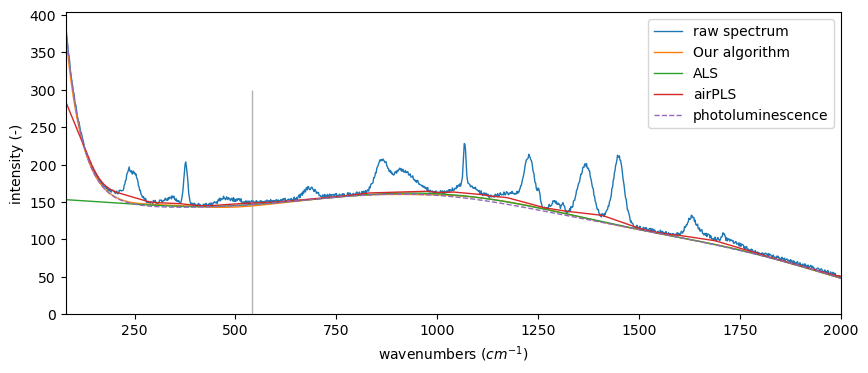

10.0% progress


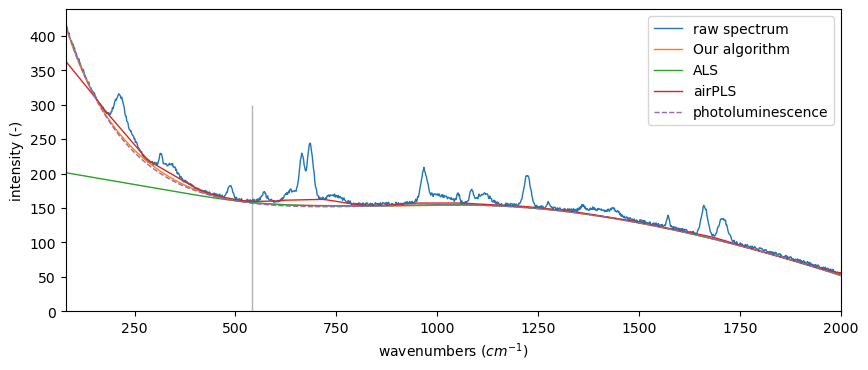

20.0% progress


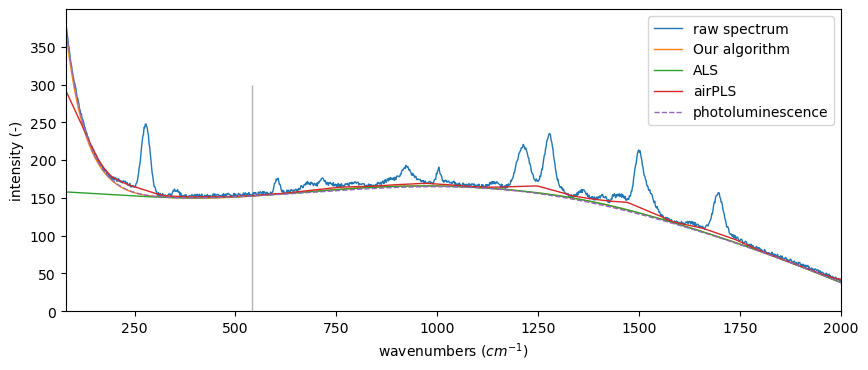

30.0% progress


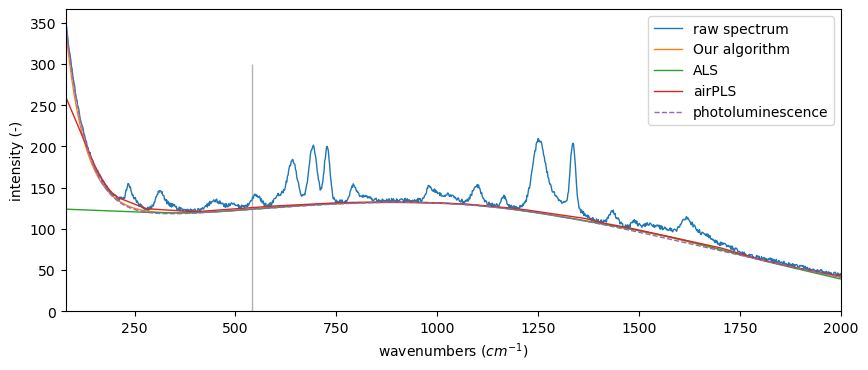

40.0% progress


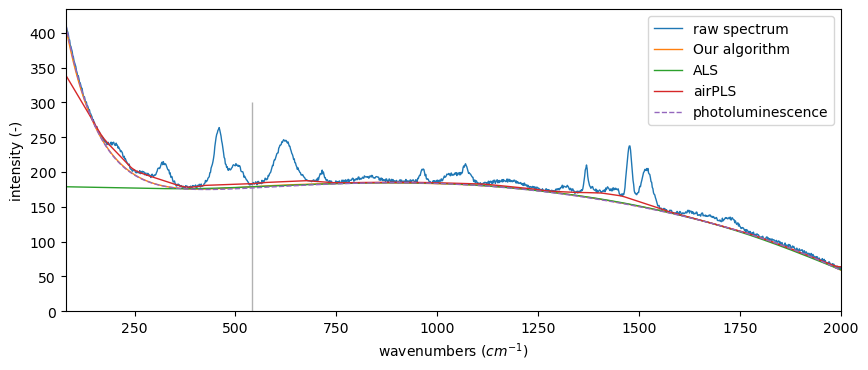

50.0% progress


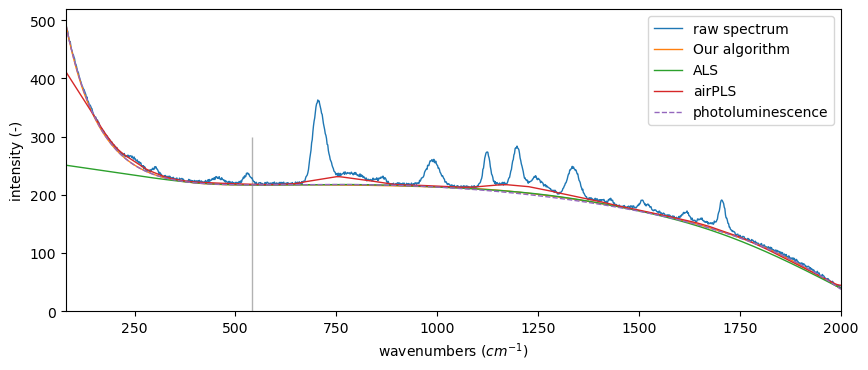

60.0% progress


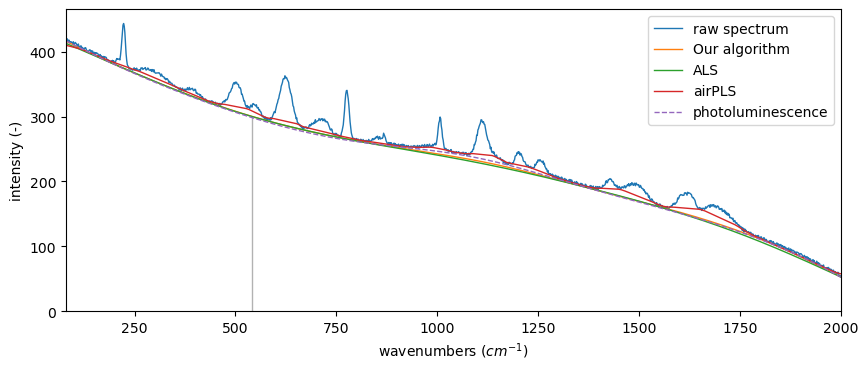

70.0% progress


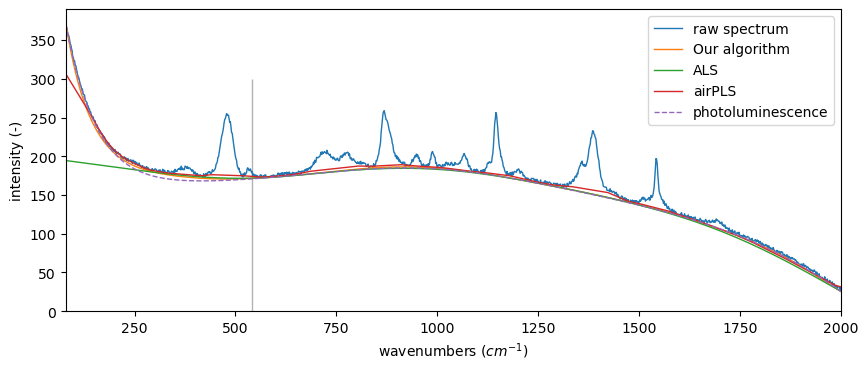

80.0% progress


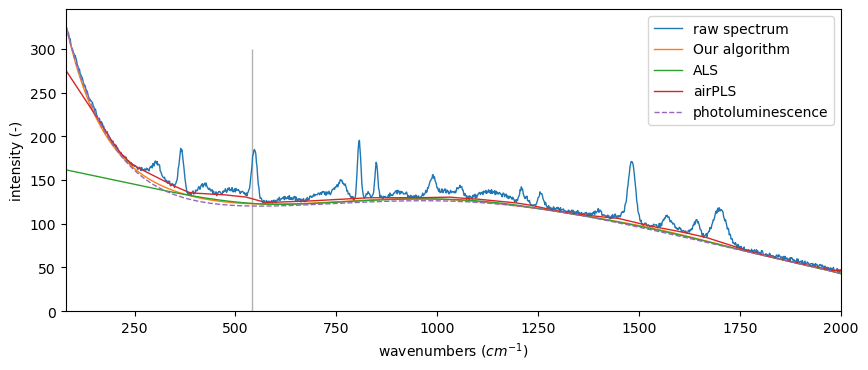

90.0% progress


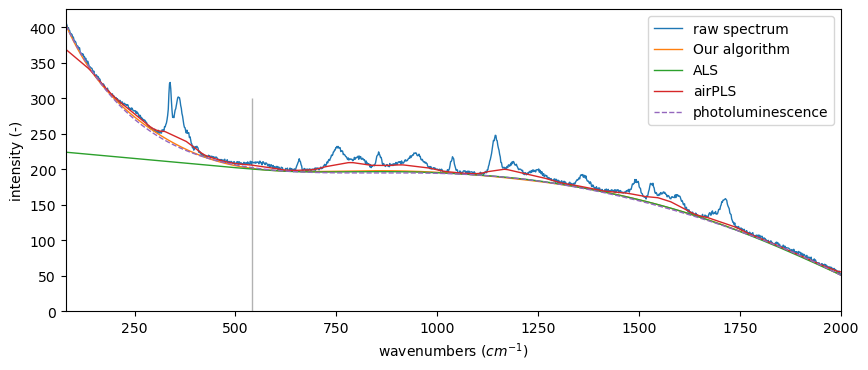

In [5]:
from BaselineRemoval import BaselineRemoval

plt.rcParams['figure.figsize'] = (10.0, 4.0)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 1

split = splitting.split(x, size=x.shape[0], FWHM=400, segment_width=450, algorithm="Bezier curve")

proposed_error = []
ALS_error = []
zhang_error = []

LEFT = 300

def calc_error_optimum(photo_org, photo, raw):
    return [error.TMSGE(photo, raw), 
            error.TMSGE(photo_org, photo), 
            error.MSGE(photo) / np.mean(raw),
            error.MSGE(photo)-error.MSGE(photo_org),            
            error.RMSE(raw, photo),
            error.RMSE(photo_org, photo),
            error.MAPE(photo, raw),
            error.MAPE(photo, photo_org)]

for j, (raw, photo_org) in enumerate(raw_lst):
    photo = split(raw.reshape(1,-1))[0]
    photo_ALS = derpsalsa.derpsalsa_baseline(x, raw, als_lambda=1e3, als_p_weight=1e-5, display=0)
    baseObj = BaselineRemoval(raw)
    photo_zhangfit = raw - baseObj.ZhangFit(lambda_=50, itermax=30)

    proposed_error.append(calc_error_optimum(photo_org, photo, raw) + calc_error_optimum(photo_org[:LEFT], photo[:LEFT], raw[:LEFT]) + calc_error_optimum(photo_org[LEFT:], photo[LEFT:], raw[LEFT:]))
    ALS_error.append(calc_error_optimum(photo_org, photo_ALS, raw) + calc_error_optimum(photo_org[:LEFT], photo_ALS[:LEFT], raw[:LEFT]) + calc_error_optimum(photo_org[LEFT:], photo_ALS[LEFT:], raw[LEFT:]))
    zhang_error.append(calc_error_optimum(photo_org, photo_zhangfit, raw) + calc_error_optimum(photo_org[:LEFT], photo_zhangfit[:LEFT], raw[:LEFT]) + calc_error_optimum(photo_org[LEFT:], photo_zhangfit[LEFT:], raw[LEFT:]))
    
#     print("new", ("{:.3f} \t"*9).format(*proposed_error[-1]))
#     print("Zha", ("{:.3f} \t"*9).format(*zhang_error[-1]))
#     plt.plot(x, raw, label="Noise removed")
#     plt.plot(x, photo.reshape(-1), label="Bezier curve appr")
#     plt.plot(x, photo_ALS, label="Derpsalsa")
#     plt.plot(x, photo_zhangfit, label="Zhang fit")
#     plt.plot(x, photo_org, "--")
#     plt.vlines(x[LEFT], 0, 300, 'k', alpha=0.3)
#     plt.ylim(0)
#     plt.xlim(x[0], x[-1])
#     plt.xlabel(r"wavenumbers ($cm^{-1}$)")
#     plt.ylabel("intensity (-)")
#     plt.legend()
#     plt.show()
#     break
    
    if not j % 100:
        print(f"{j/len(raw_lst)*100}% progress")
        plt.plot(x, raw, label="raw spectrum")
        plt.plot(x, photo.reshape(-1), label="Our algorithm")
        plt.plot(x, photo_ALS, label="ALS")
        plt.plot(x, photo_zhangfit, label="airPLS")
        plt.plot(x, photo_org, "--", label="photoluminescence")
        plt.vlines(x[LEFT], 0, 300, 'k', alpha=0.3)
        plt.ylim(0)
        plt.xlim(x[0], x[-1])
        plt.xlabel(r"wavenumbers ($cm^{-1}$)")
        plt.ylabel("intensity (-)")
        plt.legend()
        plt.show()
#         break

In [6]:
error1 = np.array(copy.copy(proposed_error))
error2 = np.array(copy.copy(ALS_error))
error3 = np.array(copy.copy(zhang_error))

In [7]:
# print(f"{np.mean(error1, 0)},\t {np.std(error1, 0)}")
# print(f"{np.mean(error2, 0)},\t {np.std(error2, 0)}")
# print(f"{np.mean(error3, 0)},\t {np.std(error3, 0)}")

In [11]:
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = (10.0, 13.0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1


def add_label(violin, label, set_labels=True):
    color = violin["bodies"][0].get_facecolor().flatten()
    if set_labels:
        labels.append((mpatches.Patch(color=color), label))
    violin['cmeans'].set_edgecolor('m')
    violin['cmeans'].set_linewidth(2)
    violin["cbars"].set_alpha(0)
    return violin

def change_box(box):
    for pc in box["medians"]:
        pc.set_color("r")
        pc.set_alpha(1)
            
    for line in ["whiskers", "boxes", "caps"]:
        for pc in box[line]:
            pc.set_linewidth(0.5)
    return box

def plot_results(error_n=0, n_errors=3, max_error=True):
    global labels 
    labels = []
    xlabels = ["whole spectrum","left hand side of spectrum","right hand side of spectrum"]
    
    fig = plt.figure()
    width = 3 - (not not skip_errors)
    gs = fig.add_gridspec(n_errors-len(skip_errors), width, hspace=0)
    axs = gs.subplots(sharex='col')
    
    i = 0
    for error_n in range(n_errors):
        if error_n in skip_errors:
            continue
        
        sub_axs = axs[i]
        sub_axs[0].set_ylabel(error_lst[error_n])
        for j in range(3-width, 3):
            ax = sub_axs[j-3+width]
            
            add_label(ax.violinplot(error1[:,error_n+n_errors*j], positions=[0+j*3],  showmeans=True), "Ours", set_labels= (j == 1) and (error_n == 1))  
            add_label(ax.violinplot(error2[:,error_n+n_errors*j], positions=[1+j*3], showmeans=True), "ALS", set_labels= (j == 1) and (error_n == 1))
            violin = add_label(ax.violinplot(error3[:,error_n+n_errors*j], positions=[2+j*3], showmeans=True), "airPLS", set_labels= (j == 1) and (error_n == 1))
            
            change_box(ax.boxplot(error1[:,error_n+n_errors*j], positions=[0+j*3], showfliers=False, widths=0.3))
            change_box(ax.boxplot(error2[:,error_n+n_errors*j], positions=[1+j*3], showfliers=False, widths=0.3))
            box = change_box(ax.boxplot(error3[:,error_n+n_errors*j], positions=[2+j*3], showfliers=False, widths=0.3))

            ax.set_xlabel(xlabels[j])
            ax.set_xticks([])
        i += 1   
        
#         # align minima for each row
#         m3 = min([ax.get_ylim()[0] for ax in sub_axs])
#         for j in range(3-width, 3):
#             ax = sub_axs[j-3+width]
#             ax.set_ylim(bottom=m3)
        
    labels.append((violin["cmeans"], "mean"))
    labels.append((box["medians"][0], "median"))
    
    if len(skip_errors) > 1:
        axs[0][0].legend(*zip(*labels))
    else:
        axs[2][1].legend(*zip(*labels))
    plt.tight_layout()
    plt.show()


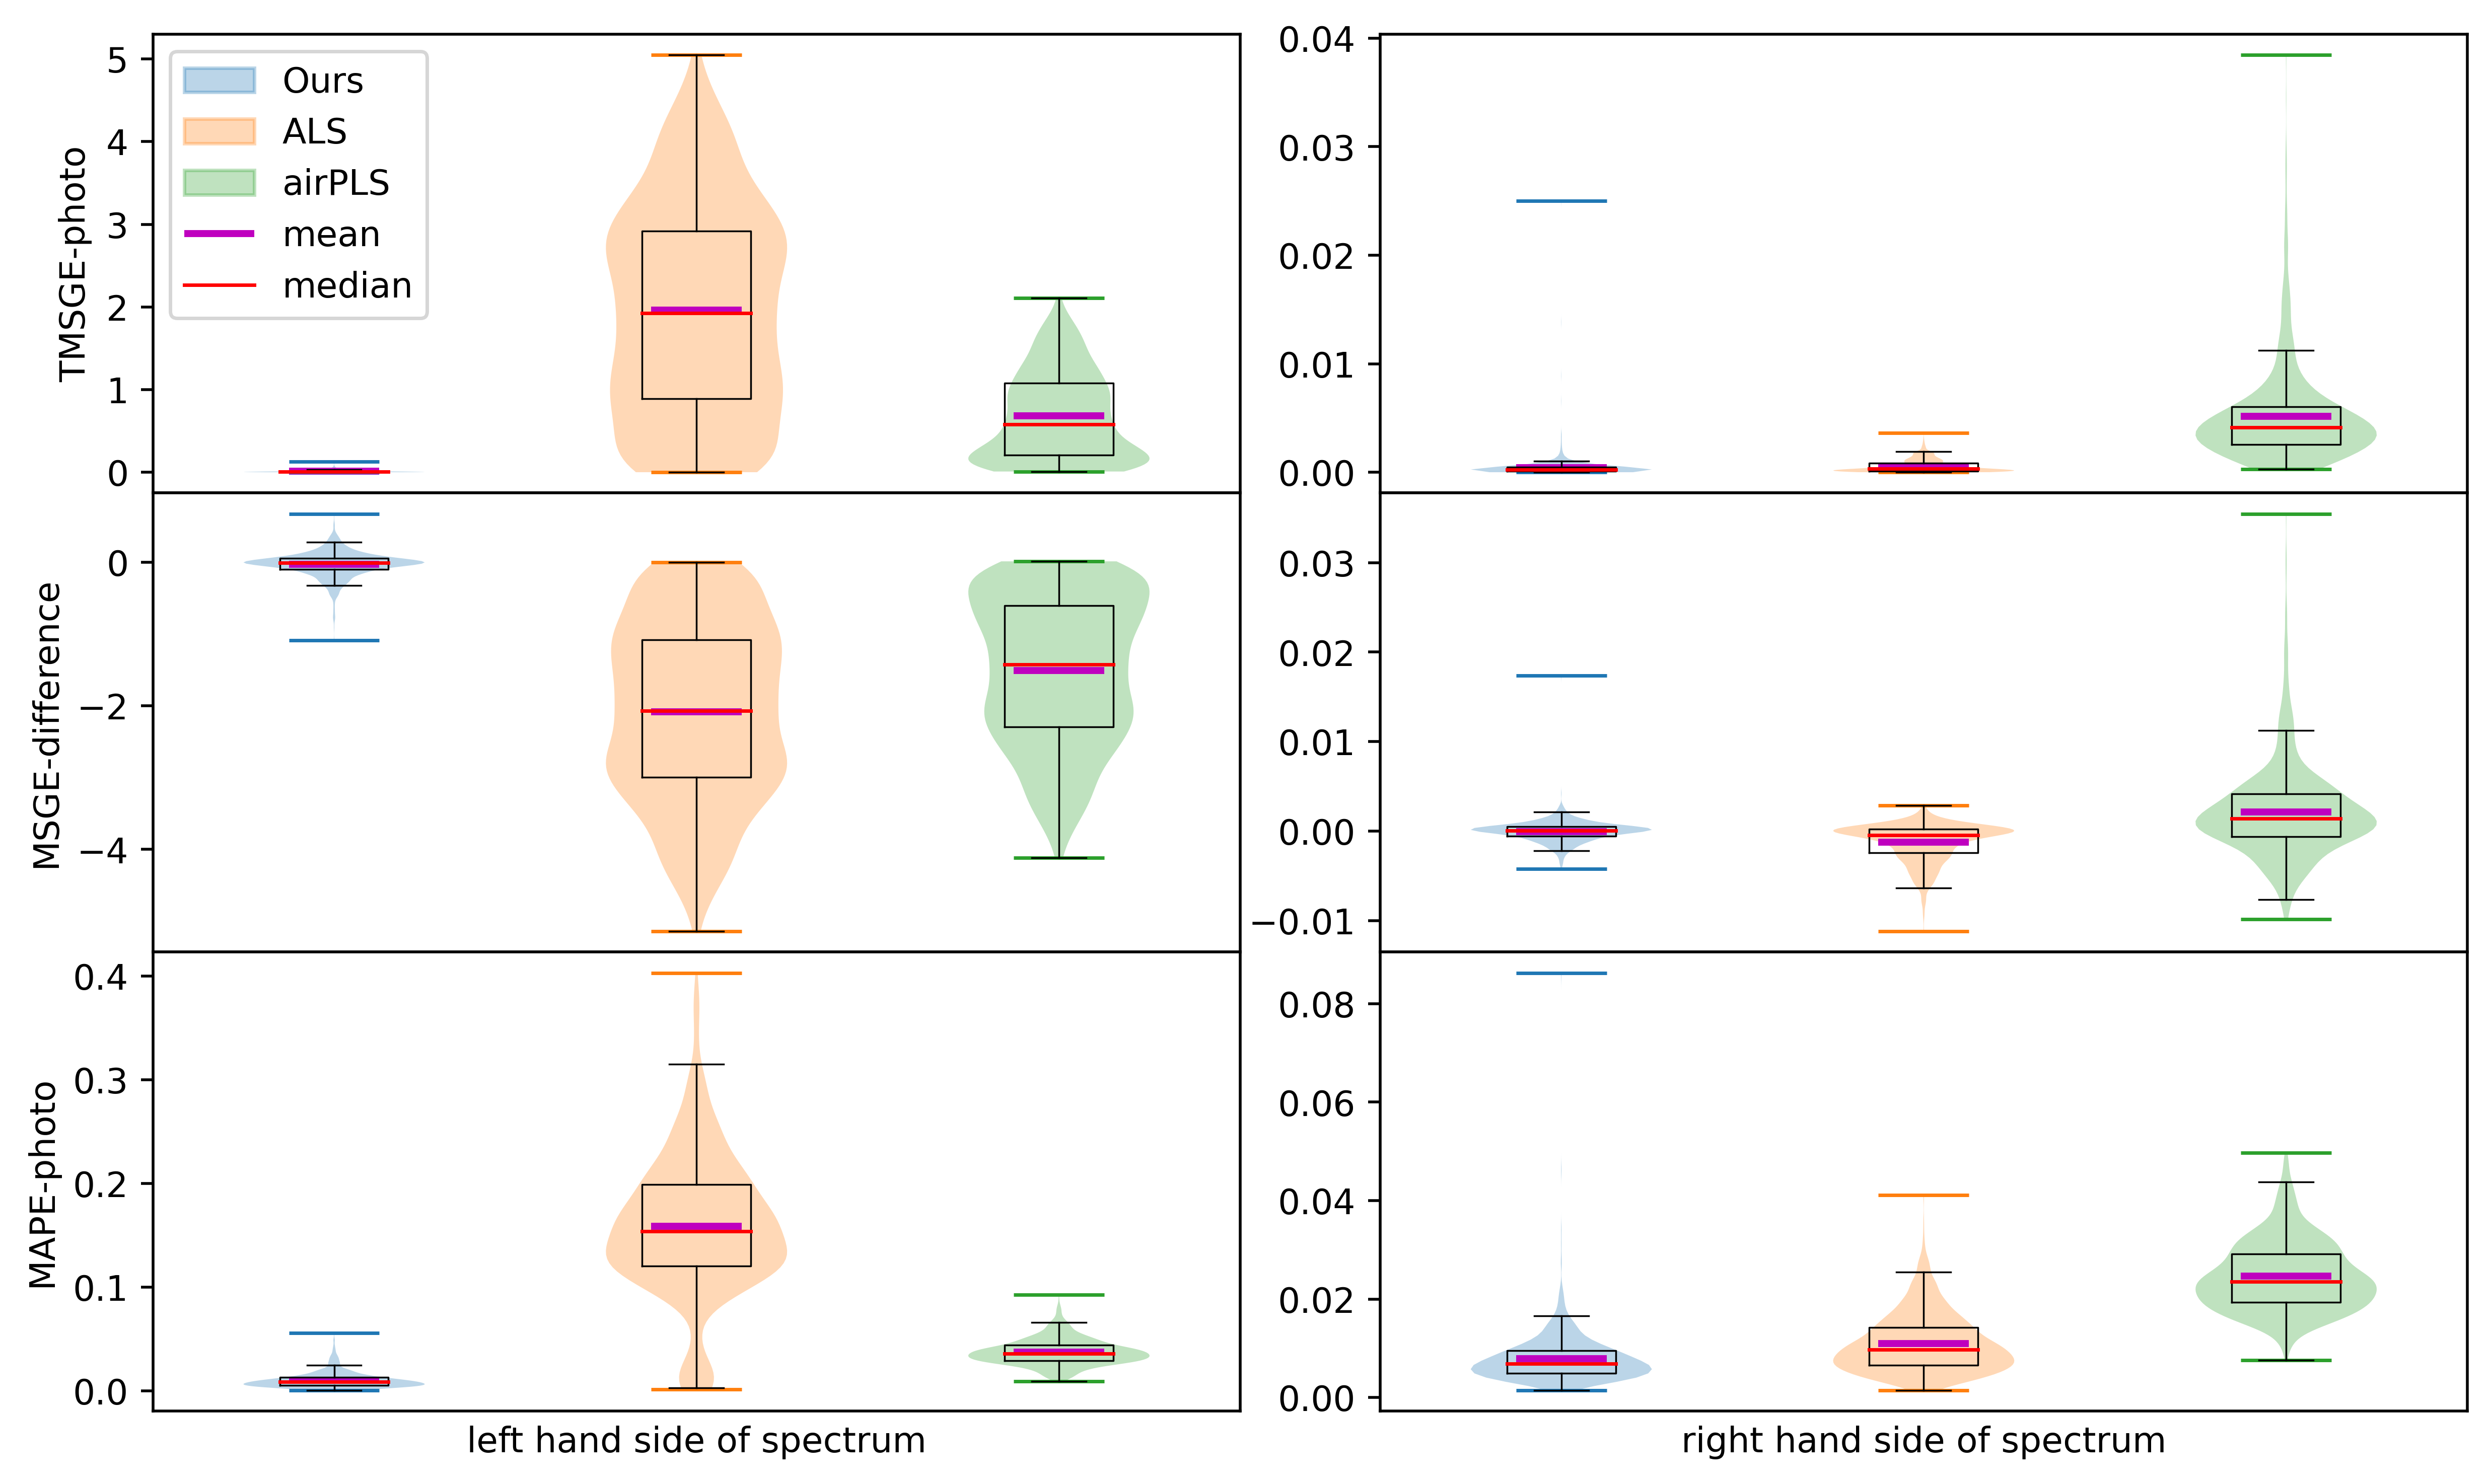

In [13]:
error_lst = ["TMSGE-raw", "TMSGE-photo", "MSGE-norm", "MSGE-difference", "RMSE-raw", "RMSE-photo", "MAPE-raw", "MAPE-photo"]

skip_errors = []
plt.rcParams['figure.figsize'] = (10.0, 13.0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1

skip_errors = [0,2,4,5,6]
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['lines.linewidth'] = 1

plot_results(0, n_errors=len(error_lst))